# EDA analysis.
## Net load on a weekly resolution. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [2]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)

COLOR_SUMMER = '#f9da21'
COLOR_WINTER = '#70b2b2'
COLOR_AUTUMN  = '#9e9e9e'
COLOR_SPRING = '#97be6d'

cmaps_hex = [COLOR_SPRING,COLOR_SUMMER,COLOR_AUTUMN,COLOR_WINTER]
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
RSEED = 42

In [3]:
# Load data for building 5
building_nr = 5
df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'})#.set_index('datetime')


In [4]:
data_df = df.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    weekofyear = lambda x: x['timestamp'].dt.weekofyear,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)
weekly_data_df = data_df\
    .groupby(['date','year','month','weekofyear','day','dayofyear'], as_index=False)\
    .agg({'net_load_kWh':np.mean})\
    .set_index('date')

/var/folders/8t/vxvv0wfd7q7_yj7gmh717sww0000gn/T/ipykernel_9522/3343951730.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  weekofyear = lambda x: x['timestamp'].dt.weekofyear,


In [5]:
season = list(np.repeat(['Winter','Spring','Summer','Autumn'],3))
season.append(season.pop(0))
# df_season = pd.DataFrame({'season':season, 'month':[month%12 // 3 + 1 for month in range(1, 13)]}, index=range(12))
df_season = pd.DataFrame({'season':season, 'month':range(1,13)}, index=range(12))
data_df = pd.merge(data_df, df_season, how='left', on='month')

In [6]:
data_df['season1'] = pd.Categorical.from_codes((data_df.month-1)//3, ['Winter','Spring','Summer','Autumn'])

In [7]:
df_winter1 = data_df[(data_df['season']=='Winter') & (data_df['weekofyear']< 20)].set_index('weekofyear')['net_load_kWh'].rolling(24,center=True, min_periods=1).mean()
df_spring = data_df[(data_df['season']=='Spring') & (data_df['weekofyear']< 30)].set_index('weekofyear')['net_load_kWh'].rolling(24, center=True, min_periods=1).mean()
df_summer = data_df[(data_df['season']=='Summer') & (data_df['weekofyear']< 40)].set_index('weekofyear')['net_load_kWh'].rolling(24, center=True, min_periods=1).mean()
df_autumn = data_df[(data_df['season']=='Autumn') & (data_df['weekofyear']< 50)].set_index('weekofyear')['net_load_kWh'].rolling(24, center=True, min_periods=1).mean()
df_winter2 = data_df[(data_df['season']=='Winter') & (data_df['weekofyear']>40)].set_index('weekofyear')['net_load_kWh'].rolling(24, center=True, min_periods=1).mean()


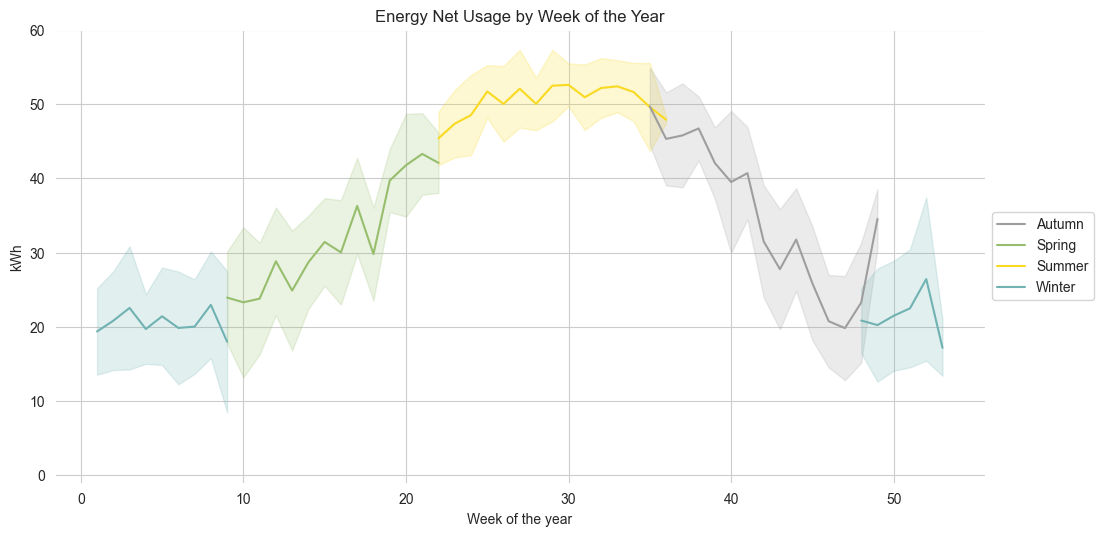

In [9]:
from matplotlib.pyplot import legend


fig, ax = plt.subplots()
ax = sns.lineplot(data = pd.DataFrame(df_winter1).rename(columns={'net_load_kWh':'Winter'}), palette=[COLOR_WINTER], ci ='sd')
ax = sns.lineplot(data = pd.DataFrame(df_spring).rename(columns={'net_load_kWh':'Spring'}), palette=[COLOR_SPRING], ci = 'sd')
ax = sns.lineplot(data = pd.DataFrame(df_summer).rename(columns={'net_load_kWh':'Summer'}), palette=[COLOR_SUMMER], ci = 'sd')
ax = sns.lineplot(data = pd.DataFrame(df_autumn).rename(columns={'net_load_kWh':'Autumn'}), palette=[COLOR_AUTUMN], ci = 'sd')
ax = sns.lineplot(data = pd.DataFrame(df_winter2).rename(columns={'net_load_kWh':'Winter'}), palette=[COLOR_WINTER], ci = 'sd')
ax.set(title = 'Energy Net Usage by Week of the Year', xlabel='Week of the year', ylabel='kWh')
ax.set_ylim(-1,60)
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[index] for index in [3,1,2,0]], [labels[index] for index in [3,1,2,0]], bbox_to_anchor=(1, 0.5), loc='center left')
fig.savefig('../images/energy_net_usage_by_weekyear.png', dpi=450, bbox_inches='tight')